# K-Means Clustering Algorithm
**Author**: James Chen, School of Animal Sciences, Virginia Tech

**Date**: Aug 3, 2022

<center><img src="https://github.com/vt-ads/intro_to_phenomics/blob/main/res/l03/cover.png?raw=1" width="900"/></center>

## **Set up the environment**
### Clone the repository (demo data and scripts)

In [1]:
# use a exclamation mark, "!", to call Shell command in Python
!git clone https://github.com/vt-ads/intro_to_phenomics

Cloning into 'intro_to_phenomics'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 340 (delta 7), reused 20 (delta 7), pack-reused 311
Receiving objects: 100% (340/340), 67.68 MiB | 28.09 MiB/s, done.
Resolving deltas: 100% (115/115), done.


### Change the working directory

In [2]:
import os
# change WD
os.chdir("/content/intro_to_phenomics")
# print WD
print("Current folder: ", os.getcwd())

Current folder:  /content/intro_to_phenomics


### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## **Data**

### Multivariate normal distribution
First, we can simulate a structured data that is sampled from two different multivariate normal distributions.


In [4]:
# number of clusters, i.e. 2 distributions
k = 2
# number of data points in each cluster
n = 50
# total number of data points
N = n * k
# cluster proerties: means and standard deviation
means = [[40, 40], [60, 70]]
stds = [[[80, 0],
         [0, 70]],
        [[60, 10],
         [10, 90]]]

# use np.random.multivariate_normal() to sample the datasets
data = []
for mean, std in zip(means, stds):
    data += [np.random.multivariate_normal(mean=mean, cov=std, size=n)]
data = np.concatenate(data)

# validation
print("Shape: ", data.shape)
print(data[:20]) #print first 20

#clustering useful for when there's structure in the data, i.e. when two SNPs are inherited together they should be clustered

Shape:  (100, 2)
[[44.52222267 21.3189503 ]
 [45.45629999 32.69473274]
 [21.52881303 51.48542165]
 [36.06866684 38.3785723 ]
 [37.51428884 41.29043799]
 [33.66108459 39.35874568]
 [26.60601524 41.18932881]
 [46.42666448 40.38240043]
 [31.61564678 35.06134615]
 [28.43758123 51.79529759]
 [47.99319621 41.20363227]
 [40.60579354 34.93933301]
 [34.05647581 41.91576152]
 [37.86984706 21.96405599]
 [40.42498701 50.87866048]
 [46.28849909 32.77192265]
 [27.25253563 51.53126048]
 [26.65837816 24.07030041]
 [42.22196884 50.67986232]
 [42.43626586 38.22211404]]


### Visualization
It is always good to visually inspect your datasets. Here, we use the library `matplotlib` to visualize the data and to confirm the simulated structure.

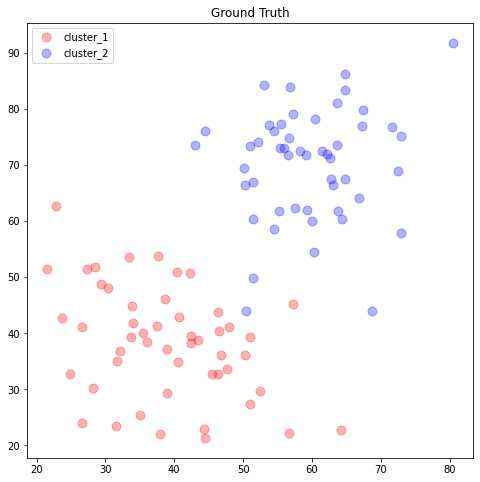

In [5]:
# plotting parameters
param_pts = dict(s=80, alpha=.3) #change size of dot and transparency
# plotting
plt.figure(figsize=(8, 8))
# data points
plt.scatter(data[:n, 0], data[:n, 1],
            c="red", label="cluster_1", **param_pts) #** is the pointer to the dictionary
plt.scatter(data[n:, 0], data[n:, 1],
            c="blue", label="cluster_2", **param_pts)
plt.title("Ground Truth")
# add plot legend
plt.legend()

## **Assumptions**
Before we cluster the given data, we may integrate our prior knowledge or assumption to the clustering algorithms for better performance in both precision and time.

### Centroids
Centroids are the centeral coordinates, or average values, of each cluster. We have to provide initial centroids to start the clustering iterations. This step is essential to the model performance as improper initial states may lead to longer converence time or non-convergent results.

In our example, however, we can randomly generate the initial centroids. As the data size is relatively small, and the data structure is clearly defined.

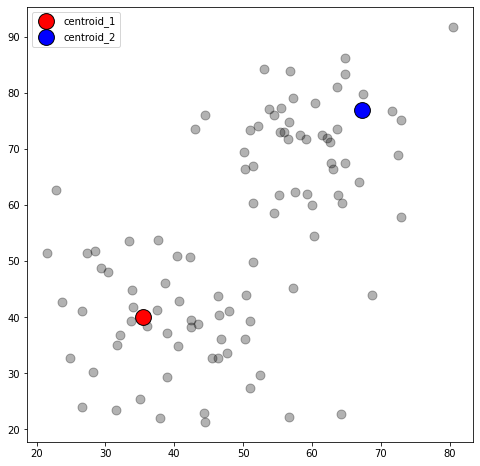

In [9]:
#np.random.seed(24061) #for setting random seed
centroids = data[np.random.choice(N, k)] #assumption of this set: what is the centroid of the cluster
# we will cover how to set k later

#in python we use choice to draw samples
#in this case since we have n =100 and k=2 we're drawing 2 samples from 100^
#when you increase k you'll always have better fitting >> overfitting, so need to remember there should be a penalty

# plotting parameters
param_pts = dict(s=80, alpha=.3)
param_cts = dict(s=250, edgecolor="black")
# plotting
plt.figure(figsize=(8, 8))
# data points
plt.scatter(data[:, 0], data[:, 1], c="black", **param_pts)
# centroids
plt.scatter(centroids[0, 0], centroids[0, 1],
            c="red", label="centroid_1", **param_cts)
plt.scatter(centroids[1, 0], centroids[1, 1],
            c="blue", label="centroid_2", **param_cts)
# add plot legend
plt.legend()

### Distance
The distance deviation between the centroids and each data point is another key component in clustering algorithm. This is a guidance (loss function) for the model to be trained and generate ideal outcomes. For example, if we want to cluster a genetic sequence based on their recombination rates, we have to take genetic distances into consideration when we define the loss function.

But again, in this note, we try to keep everything as simple as possible. The distance between data points will be evaluted by Euclidean distance.

In [10]:
# define the evaluation function
# in this case we use distance as a parameter to tell the computer what's close and should be clustered
def euclidean_distance(x, y):
    return np.sum((x - y) ** 2) ** .5

# validate the result
x = np.array([0, 0])
y = np.array([3, 4])
print("the distance is: ", euclidean_distance(x, y))

the distance is:  5.0


## **Clustering algorithm**
K-Means clustering algorithm consists of two major stages: `assignment` and `update`. Iteratively implementing these two stages is expected to cluster the given datasets based on the defined distance function and provided centroids.

### Assignment stage
In this stage, each point will be assigned to the cluster that has the shortest distance from its centroid.
<center><img src="https://github.com/vt-ads/intro_to_phenomics/blob/main/res/l03/assignment.png?raw=1" width="800"/></center>

In [12]:
# collect the data parameters
#first stage is assignment stage
#calc distance of every data pt to centroids, if a pt is closer to a centroid it's assigned to that one
N = len(data) # len() is like length() in R
k = len(centroids)

# create an empty matrix to keep all evaluated distances
distances = np.zeros((N, k)) #for an N by k matrix

# iterate through each data point, nested for loop
for i, x in enumerate(data):  # i:0, 1, 2, 3, 4; x: data[0], data[1], data[2]
    # iterate through each cluster
    for j, center in enumerate(centroids): # j:0, 1; center: centroids[0], centroids[1]
        distances[i, j] = euclidean_distance(x, center) #center is centroid 1 and centroid 2

# this will return the position of the smallest values
labels = np.argmin(distances, axis=1)

# validation
print("Assigned cluster: \n", labels)

Assigned cluster: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Update stage
<center><img src="https://github.com/vt-ads/intro_to_phenomics/blob/main/res/l03/update.png?raw=1" width="800"/></center>

In [13]:
# after we've assigned clustering we need to update our centroid
#it's like a posterior to update centroid 
#create an empty matrix to keep the new centroids
new_centroids = np.zeros((k, 2))

# iterate over each cluster
for i in range(k):
    new_centroids[i] = data[labels == i].mean(axis=0) #when label == i it means we want to calc new average value

# validation
print("New center: \n", new_centroids)

New center: 
 [[39.40535904 38.68464165]
 [59.93109231 71.07202723]]


### Another assignment stage

In [14]:
#for better visualization
distances = np.zeros((N, k))
for i, x in enumerate(data):
    for j, center in enumerate(new_centroids):
        distances[i, j] = euclidean_distance(x, center)
new_labels = np.argmin(distances, axis=1)

### Visualize the outcome

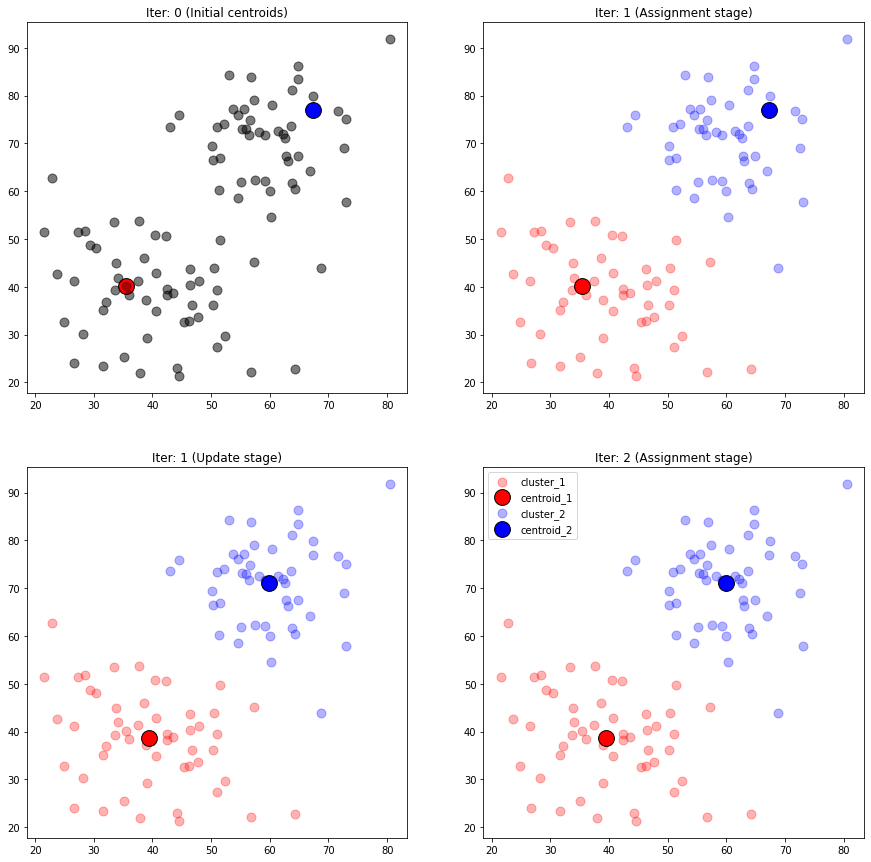

In [15]:
# inner loop
param_pts = [dict(c="red",  label="cluster_1", s=80, alpha=.3),
             dict(c="blue", label="cluster_2", s=80, alpha=.3)]
param_cts = [dict(c="red",  label="centroid_1", s=250, edgecolor="black"),
             dict(c="blue", label="centroid_2", s=250, edgecolor="black")]

# outer loop
titles = ["Iter: 0 (Initial centroids)",
          "Iter: 1 (Assignment stage)",
          "Iter: 1 (Update stage)",
          "Iter: 2 (Assignment stage)"]
ls_data = [[data[:n],            data[n:]],
           [data[labels==0],     data[labels==1]],
           [data[labels==0],     data[labels==1]],
           [data[new_labels==0], data[new_labels==1]]]
ls_cts  = [centroids,
           centroids,
           new_centroids,
           new_centroids]

# create a new figure
fig = plt.figure(figsize=(15, 15))
# iterate over subplots
for (i, title, pts, cts) in zip(range(4), titles, ls_data, ls_cts):
    axis = fig.add_subplot(2, 2, i + 1)
    axis.set_title(title)
    # iterate over clusters
    for (pt, ct, param_pt, param_ct) in zip(pts, cts, param_pts, param_cts):
        if i != 0:
            axis.scatter(x=pt[:, 0], y=pt[:, 1], **param_pt)
        else:
            axis.scatter(x=data[:, 0], y=data[:, 1], label="unlabeled data", c="black", s=80, alpha=.3)
        axis.scatter(x=ct[0], y=ct[1], **param_ct)
axis.legend(loc='upper left')

### Put things together
We can collect all code blocks and put them into one signle function `kmeans(X, k)`, where `X` is a 2D matrix in a shape of `(n, p)`, and `k` is the number of clusters.

<center><img src="https://github.com/vt-ads/intro_to_phenomics/blob/main/res/l03/kmeans.png?raw=1" width="600"/></center>

In [26]:
def kmeans(X, k, niter=20):
    centers = init_centers(X, k)
   
    for i in range(k):
      labels[i] = assignment (X, [centers == i])
      centers[i] = update (X, [labels == i], K)
    return dict(labels=labels, centers=centers)

print (labels)
print (centers)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


NameError: ignored

In [19]:
kmean = kmeans(X=data, k=2, niter=3)
kmean

NameError: ignored

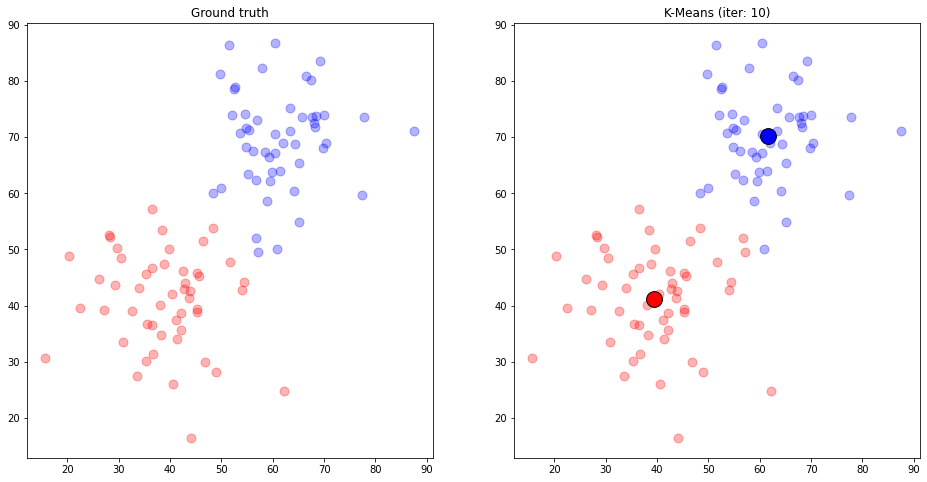

In [ ]:
titles  = ["Ground truth", "K-Means (iter: 10)"]
ls_data = [[data[:n],                 data[n:]],
           [data[kmean["labels"]==0], data[kmean["labels"]==1]]]
ls_cts  = [centroids, kmean["centers"]]

# create a new figure
fig = plt.figure(figsize=(16, 8))
# iterate over subplots
for (i, title, pts, cts) in zip(range(2), titles, ls_data, ls_cts):
    axis = fig.add_subplot(1, 2, i + 1)
    axis.set_title(title)
    # iterate over clusters
    for (pt, ct, param_pt, param_ct) in zip(pts, cts, param_pts, param_cts):
        axis.scatter(x=pt[:, 0], y=pt[:, 1], **param_pt)
        if i != 0:
            axis.scatter(x=ct[0], y=ct[1],   **param_ct)

            #if you don't choose your center wisely you'll end up with localized optimization that does not represent total data


## *Work with real data*
### Load the image

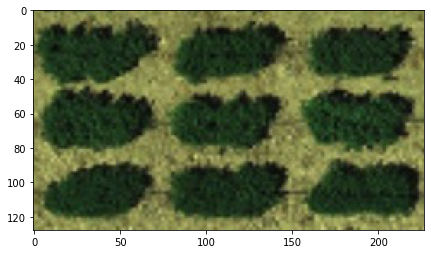

In [27]:
from modules.image_handler import load_img
img = load_img("data/plots.jpg")
plt.figure(figsize=(7, 7))
plt.imshow(img)

#goal: to segment vegation from soil

### Dataframe

In [28]:
#reshape row x column based on our image
import pandas as pd
df = pd.DataFrame(img.reshape((-1, 3))) #-1 means figure out on your own
df.columns = ["red", "green", "blue"]
print(df)

       red  green  blue
0      134    135    75
1      150    152    89
2      157    162    96
3      169    174   107
4      156    163    96
...    ...    ...   ...
29051  181    185   111
29052  162    166    92
29053  121    120    56
29054  132    131    67
29055  173    173   109

[29056 rows x 3 columns]


In [29]:
#plot ea pixel as a point along RGB axes
import plotly
import plotly.express as px
import plotly.graph_objs as go
dfs = df.iloc[::100, ] # sample 1 data point every 100 pixels
points = go.Scatter3d(x=dfs.red, y=dfs.green, z=dfs.blue,
                    mode='markers', name='pixel value',
                    marker=dict(size=5, symbol='circle', opacity=0.7))
layout = go.Layout(scene=dict(xaxis=dict(title="red"),
                              yaxis=dict(title="green"),
                              zaxis=dict(title="blue")),
                   margin=dict(l=100, r=200, b=0, t=0))
fig = go.Figure(data=[points], layout=layout)
fig.show()

In [30]:
#borrow package from Kmean b/c do it in python is v slow so you do C in it
#use sklearn to implement kmean
from modules.kmeans import KMeans_sklearn
h, w, c = img.shape
data = img.reshape((-1, c))
kmean = KMeans_sklearn(X=data, k=3) #k is how many clusters we want

Text(0.5, 1.0, 'Clustered image')

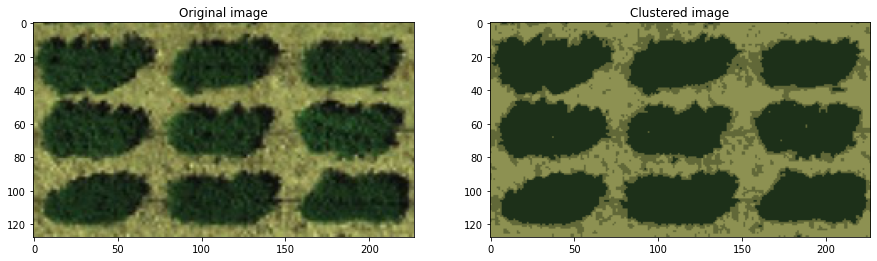

In [31]:
labels = kmean["labels"]
centers = kmean["centers"].astype(int)
img_new = centers[labels].reshape((h, w, c))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("Original image")
axes[1].imshow(img_new)
axes[1].set_title("Clustered image")

#so segmented out vegetation

In [32]:
colors     = ["rgb(%d, %d, %d)" % tuple(color.tolist()) for color in centers]
dfs        = df.iloc[::100]
labels_sub = labels[::100]
ls_points  = []
for i in range(3):
    ls_points += [go.Scatter3d(x=dfs.loc[labels_sub==i, "red"],
                               y=dfs.loc[labels_sub==i, "green"],
                               z=dfs.loc[labels_sub==i, "blue"],
                               mode='markers', name='cluster_%d' % (i + 1),
                               marker=dict(size=5, symbol='circle', opacity=0.7))]
# layout
layout = go.Layout(scene=dict(xaxis=dict(title="red"),
                              yaxis=dict(title="green"),
                              zaxis=dict(title="blue")),
                   margin=dict(l=100, r=200, b=0, t=0))
# show
fig = go.Figure(data=ls_points, layout=layout)
fig.show()